<a href="https://colab.research.google.com/github/CeciASanz/NLP/blob/main/Ejercicio%204/4d%20-%20predicci%C3%B3n_palabra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if platform.system() == 'Windows':
    !curl https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt -o H_P_and_the%20Sorcerers_Stone.txt
else:
    !wget H_P_and_the%20Sorcerers_Stone.txt https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt

--2023-08-27 20:08:05--  http://h_p_and_the%20sorcerers_stone.txt/
Resolving h_p_and_the sorcerers_stone.txt (h_p_and_the sorcerers_stone.txt)... failed: Name or service not known.
wget: unable to resolve host address ‘h_p_and_the sorcerers_stone.txt’
--2023-08-27 20:08:05--  https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456722 (446K) [text/plain]
Saving to: ‘H_P_and_the Sorcerers_Stone.txt.2’

H_P_and_the Sorcere 100%[===================>] 446.02K  --.-KB/s    in 0.03s   

2023-08-27 20:08:06 (16.0 MB/s) - ‘H_P_and_the Sorcerers_Stone.txt.2’ saved [456722/456722]

FINISHED --2023-08-27 20:08:06--
Total wall clock time: 1.7s
Downloaded: 1 files, 446K in 0.0

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('H_P_and_the Sorcerers_Stone.txt', sep='/n', header=None)
df.head()

<ipython-input-3-0c798be8271a>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('H_P_and_the Sorcerers_Stone.txt', sep='/n', header=None)


,0
0,Harry Potter and the Sorcerer’s Stone
1,By J.K. Rowling
2,CHAPTER ONE
3,The Boy Who Lived
4,"Mr. and Mrs. Dursley, of number four, Privet D..."


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3000


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [36]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

from tensorflow.keras.layers import Bidirectional

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Harry Potter and the Sorcerer’s Stone'

In [7]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['harry', 'potter', 'and', 'the', 'sorcerer’s', 'stone']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [8]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [9]:
# Demos un vistazo
sentence_tokens[:2]

[['harry', 'potter', 'and', 'the', 'sorcerer’s', 'stone'],
 ['by', 'j', 'k', 'rowling']]

In [10]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [11]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['harry', 'potter', 'and', 'the'], ['potter', 'and', 'the', 'sorcerer’s']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [12]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [13]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[4, 1, 2, 3], [1, 2, 3, 5]]

In [14]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [15]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

5


In [15]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'potter': 1, 'and': 2, 'the': 3, 'harry': 4, 'sorcerer’s': 5}


In [16]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'and': 2, 'potter': 2, 'harry': 1, 'the': 2, 'sorcerer’s': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [17]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                 Harry Potter and the Sorcerer’s Stone
1                                       By J.K. Rowling
2                                           CHAPTER ONE
3                                     The Boy Who Lived
4     Mr. and Mrs. Dursley, of number four, Privet D...
5     Mr. Dursley was the director of a firm called ...
6     The Dursleys had everything they wanted, but t...
7     When Mr. and Mrs. Dursley woke up on the dull,...
8     None of them noticed a large, tawny owl flutte...
9     At half past eight, Mr. Dursley picked up his ...
10    “Little tyke,” chortled Mr. Dursley as he left...
11    It was on the corner of the street that he not...
12    But on the edge of town, drills were driven ou...
13    Mr. Dursley always sat with his back to the wi...
14    He’d forgotten all about the people in cloaks ...
15    “The Potters, that’s right, that’s what I hear...
Name: 0, dtype: object

In [18]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Harry Potter and the Sorcerer’s Stone By J.K. Rowling CHAPTER ONE The Boy Who Lived Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the 

In [19]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['harry',
 'potter',
 'and',
 'the',
 'sorcerer’s',
 'stone',
 'by',
 'j',
 'k',
 'rowling',
 'chapter',
 'one',
 'the',
 'boy',
 'who',
 'lived',
 'mr',
 'and',
 'mrs',
 'dursley']

In [20]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 80965


In [21]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [22]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['harry', 'potter', 'and', 'the'],
 ['potter', 'and', 'the', 'sorcerer’s'],
 ['and', 'the', 'sorcerer’s', 'stone'],
 ['the', 'sorcerer’s', 'stone', 'by'],
 ['sorcerer’s', 'stone', 'by', 'j'],
 ['stone', 'by', 'j', 'k'],
 ['by', 'j', 'k', 'rowling'],
 ['j', 'k', 'rowling', 'chapter'],
 ['k', 'rowling', 'chapter', 'one'],
 ['rowling', 'chapter', 'one', 'the'],
 ['chapter', 'one', 'the', 'boy'],
 ['one', 'the', 'boy', 'who'],
 ['the', 'boy', 'who', 'lived'],
 ['boy', 'who', 'lived', 'mr'],
 ['who', 'lived', 'mr', 'and'],
 ['lived', 'mr', 'and', 'mrs'],
 ['mr', 'and', 'mrs', 'dursley'],
 ['and', 'mrs', 'dursley', 'of'],
 ['mrs', 'dursley', 'of', 'number'],
 ['dursley', 'of', 'number', 'four']]

In [23]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[8, 141, 3, 1],
 [141, 3, 1, 649],
 [3, 1, 649, 157],
 [1, 649, 157, 73],
 [649, 157, 73, 3690],
 [157, 73, 3690, 3691],
 [73, 3690, 3691, 3692],
 [3690, 3691, 3692, 621],
 [3691, 3692, 621, 40],
 [3692, 621, 40, 1],
 [621, 40, 1, 145],
 [40, 1, 145, 63],
 [1, 145, 63, 1082],
 [145, 63, 1082, 148],
 [63, 1082, 148, 3],
 [1082, 148, 3, 272],
 [148, 3, 272, 223],
 [3, 272, 223, 7],
 [272, 223, 7, 650],
 [223, 7, 650, 331]]

In [24]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 80961


### 3 - Input y target

In [25]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [26]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [27]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [28]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(80961, 3)
(80961,)


In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: '”',
 3: 'and',
 4: 'to',
 5: 'a',
 6: 'he',
 7: 'of',
 8: 'harry',
 9: 'was',
 10: 'it',
 11: 'in',
 12: 'his',
 13: 'you',
 14: 'said',
 15: '—',
 16: 'had',
 17: 'on',
 18: 'at',
 19: 'they',
 20: 'that',
 21: 'as',
 22: 'him',
 23: 'i',
 24: 'but',
 25: 'with',
 26: 'ron',
 27: 'all',
 28: 'out',
 29: 'up',
 30: 'for',
 31: 'be',
 32: 'them',
 33: 'hagrid',
 34: 'were',
 35: 'have',
 36: 'what',
 37: 'there',
 38: 'back',
 39: 'hermione',
 40: 'one',
 41: 'from',
 42: 'this',
 43: 'not',
 44: 'if',
 45: 'she',
 46: 'about',
 47: 'into',
 48: 'their',
 49: 'been',
 50: 'me',
 51: 'so',
 52: 'know',
 53: 'off',
 54: 'didn’t',
 55: 'like',
 56: 'could',
 57: 'got',
 58: 'get',
 59: '“i',
 60: 'her',
 61: 'down',
 62: 'when',
 63: 'who',
 64: 'over',
 65: 'looked',
 66: 'professor',
 67: 'just',
 68: 'very',
 69: 'is',
 70: 'see',
 71: 'then',
 72: 'no',
 73: 'by',
 74: 'do',
 75: 'your',
 76: 'are',
 77: 'now',
 78: 'around',
 79: 'dumbledore',
 80: 'he’d',
 81: 'snape'

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6690

In [33]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [31]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [32]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(80961, 6690)

### 4 - Entrenar el modelo

In [33]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [34]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6690

In [35]:
embed_size = np.power(vocab_size, 1/4)
embed_size


9.043916197461924

In [38]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=9, input_length=input_seq_len))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 9)              60219     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           37888     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6690)              220770    
                                                      

In [39]:
hist = model.fit(x_data, y_data, epochs=20, validation_split=0.2)

Epoch 1/20
2024/2024 [==============================] - 32s 13ms/step - loss: 6.7674 - accuracy: 0.0449 - val_loss: 6.6789 - val_accuracy: 0.0419
Epoch 2/20
2024/2024 [==============================] - 19s 9ms/step - loss: 6.3820 - accuracy: 0.0474 - val_loss: 6.6098 - val_accuracy: 0.0477
Epoch 3/20
2024/2024 [==============================] - 20s 10ms/step - loss: 6.1571 - accuracy: 0.0560 - val_loss: 6.6191 - val_accuracy: 0.0566
Epoch 4/20
2024/2024 [==============================] - 22s 11ms/step - loss: 5.9740 - accuracy: 0.0667 - val_loss: 6.5919 - val_accuracy: 0.0595
Epoch 5/20
2024/2024 [==============================] - 20s 10ms/step - loss: 5.7947 - accuracy: 0.0825 - val_loss: 6.5755 - val_accuracy: 0.0823
Epoch 6/20
2024/2024 [==============================] - 19s 9ms/step - loss: 5.6296 - accuracy: 0.0974 - val_loss: 6.6239 - val_accuracy: 0.0901
Epoch 7/20
2024/2024 [==============================] - 18s 9ms/step - loss: 5.4825 - accuracy: 0.1082 - val_loss: 6.6488 - va

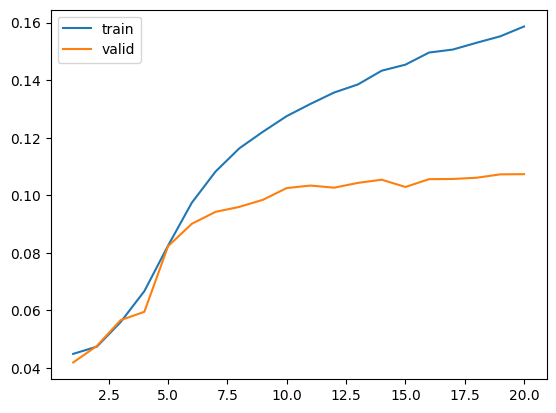

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [41]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [42]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [43]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-43-2a8fe09160a6>:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [44]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [45]:
input_text='harry potter and'

generate_seq(model, tok, input_text, max_length=3, n_words=5)

1/1 [==============================] - 0s 20ms/step


'harry potter and to for   '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

### Cambios realizados
Utilice el libro Harry Potter and the Sorcerer's Stone.

Se realizaron distintas pruebas:


*   Configuración original

  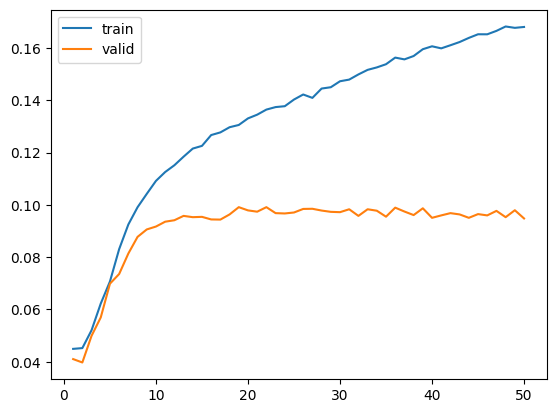

* Agregado de una capa LSTM más

  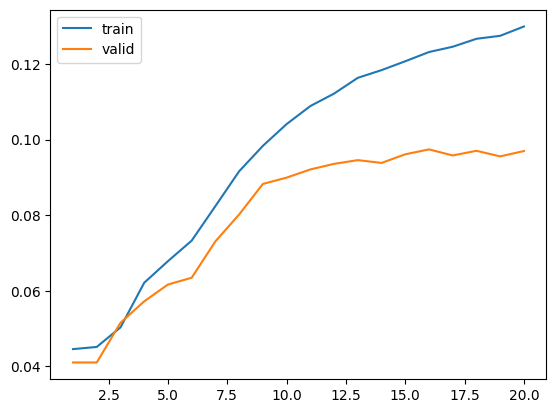

* Se modificó el embedding a la raíz cuarta del tamaño del vocabulario y se utilizó BRNN
  
  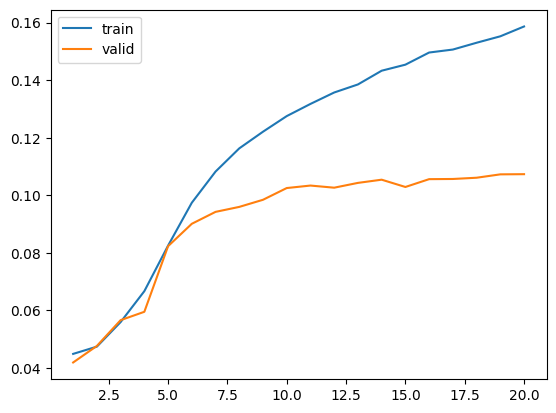


### Conclusiones

A pesar de los cambios realizados no se nota una mejoría en el desempeño, los entrenamientos a partir de la época 10 comienzan a mostrar overfitting por eso no intente probar con un entrenamiento mas extenso.